In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from matplotlib import cm

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import plotting
from src.utils import combine_prediction_files, compute_network_avg_prediction

Low Corr Features: ['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_10', 'amp_ratio_18', 'signal_dominant_frequency',
       **'noise_variance'**, **'source_depth_km'**,
       **'source_receiver_distance_logkm'**,
       **'source_receiver_back_azimuth_deg'**]

Selected Features: ['amp_1',
                    'amp_2',
                    'amp_4',
                    **'noise_variance',
                    'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'**]

# Load in the necessary data

## The model results summaries

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
lowcorr_feat_dir = os.path.join(datadir, 's_models', 'lowCorrFeatures_constHP')
results_df = pd.read_csv(os.path.join(lowcorr_feat_dir, 'all.stat.results.csv'))
results_rfecvfeats_df = pd.read_csv(os.path.join(datadir, 's_models','selected_features_constHP', 'all.stat.results.csv'))

In [3]:
results_df.head()

,train_r2,train_rmse,test_r2,test_rmse,holdout_r2,holdout_rmse,station,phase
0,0.959,0.116,0.913,0.175,0.869,0.193,YHB,S
1,0.954,0.123,0.866,0.236,0.897,0.167,YHL,S
2,0.962,0.107,0.923,0.153,0.907,0.176,YMR,S
3,0.930,0.121,0.874,0.165,0.848,0.165,YHH,S
4,0.962,0.107,0.888,0.204,NaN,NaN,B207,S


## The example counts

In [4]:
## READ IN DF FOR COUNTS ##
split_cnts = pd.read_csv(os.path.join(datadir, 'feature_splits', 's.station.ex.counts.csv'))
df_2023 = pd.read_csv(os.path.join(datadir, 'feature_splits', 's.20230101.csv'))
split_cnts.head()

,station,cnt_train,cnt_test,cnt_holdout
0,YNR,2090.0,541.0,99.0
1,YMR,1533.0,392.0,172.0
2,YMC,1443.0,363.0,171.0
3,YHB,1248.0,331.0,225.0
4,YHH,1222.0,328.0,113.0


## The model predictions

In [5]:
all_stats = results_df['station']
train_preds_df = combine_prediction_files(all_stats, lowcorr_feat_dir,'S', 'train')
test_preds_df = combine_prediction_files(all_stats, lowcorr_feat_dir,'S', 'test')
train_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60000622,0.694976,0.612082,YHB
1,60001367,2.155231,2.055494,YHB
2,60001437,2.543478,2.504374,YHB
3,60001517,2.080642,1.980400,YHB
4,60001572,1.630087,1.530092,YHB
...,...,...,...,...
239,60516997,0.857505,0.957822,YDD
240,60518152,0.756163,1.064127,YDD
241,60519152,1.920408,1.820454,YDD
242,60521912,0.755231,0.855154,YDD


In [6]:
holdout_preds_df = combine_prediction_files(df_2023['station'].unique(), lowcorr_feat_dir,'S', 'holdout')
holdout_preds_df

,Evid,magnitude,predicted_magnitude,station
0,60528982,1.363650,1.373473,YMC
1,60529052,1.338398,1.253039,YMC
2,60529562,0.843194,0.644258,YMC
3,60529752,1.289612,1.126021,YMC
4,60529762,0.986834,1.068632,YMC
...,...,...,...,...
7,60553712,1.861026,2.012235,FLWY
8,60553732,2.405604,2.475490,FLWY
9,60554092,1.788850,1.900775,FLWY
10,60554577,1.558406,1.869169,FLWY


In [7]:
# Filter split counts to only stats with models
split_cnts = split_cnts[split_cnts['station'].isin(all_stats)]

# Look at the scores from various splits

In [8]:
results_df['train_r2'].describe()

count    18.000000
mean      0.950167
std       0.020232
min       0.898000
25%       0.942000
50%       0.960000
75%       0.962000
max       0.973000
Name: train_r2, dtype: float64

In [9]:
results_df['test_r2'].describe()

count    18.000000
mean      0.820889
std       0.090146
min       0.638000
25%       0.767250
50%       0.852500
75%       0.897000
max       0.923000
Name: test_r2, dtype: float64

In [10]:
results_df['holdout_r2'].describe()

count    15.000000
mean      0.541133
std       0.770657
min      -2.026000
25%       0.707500
50%       0.841000
75%       0.865500
max       0.926000
Name: holdout_r2, dtype: float64

In [11]:
(test_preds_df['magnitude'] - test_preds_df['predicted_magnitude']).describe()

count    3327.000000
mean        0.016777
std         0.188880
min        -1.210095
25%        -0.084713
50%         0.014079
75%         0.111390
max         1.530315
dtype: float64

In [12]:
(holdout_preds_df['magnitude'] - holdout_preds_df['predicted_magnitude']).describe()

count    1185.000000
mean        0.017358
std         0.198651
min        -0.635748
25%        -0.104127
50%         0.010896
75%         0.120952
max         1.541154
dtype: float64

# Make tables/heatmaps to compare the scores

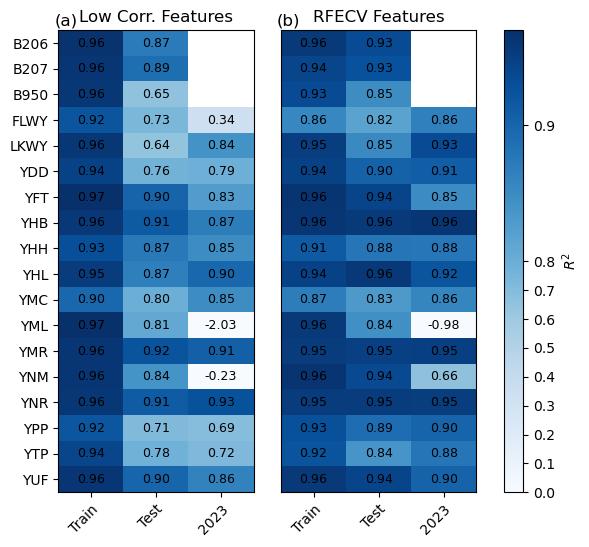

In [23]:
fig, axes = plt.subplots(1, 3, width_ratios=[2, 2, 0.2], figsize=(6, 6))

midpoint_normalize = True
midpoint = 0.8
cmap_min = 0
cmap_max = 0.97
xlabels=['Train', 'Test', '2023']

im1 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Low Corr. Features',
                        ax=axes[0],
                        show_ylabels=True,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
im2 = plotting.scores_heatmap(results_rfecvfeats_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='RFECV Features',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=False,
                        xticklabels=xlabels,
                        tablefontsize=9)
plt.colorbar(im2, cax=axes[2], label=f'$R^2$', ticks=np.arange(0, 1.0, 0.1))

sp_labels = ['(a)', '(b)']
for i, ax in enumerate(axes[:-1]):
    ax.text(-0.02, 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
#fig.tight_layout()
fig.show()

cmap midpoint set to 172.0
cmap min set to 2.0
cmap max set to 2090.0
cmap min set to -1.0439999999999998
cmap max set to 0.06500000000000006


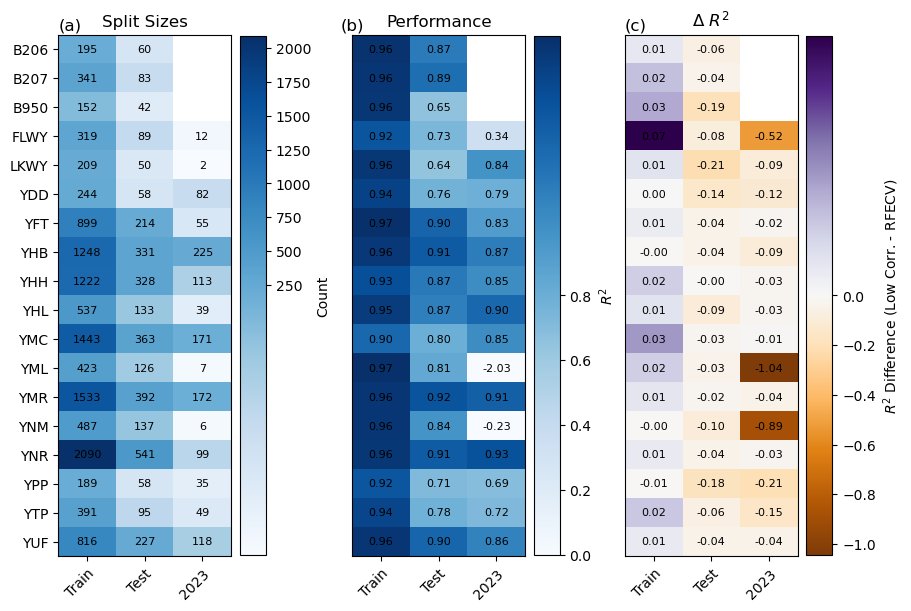

In [24]:
diff_df = results_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']] - results_rfecvfeats_df.sort_values('station')[['train_r2', 'test_r2', 'holdout_r2']]
diff_df['station'] = results_df.sort_values('station')['station']
fig, axes = plt.subplots(1, 3, figsize=(9, 6), constrained_layout=True) #, width_ratios=[2, 2, 0.2], figsize=(6, 6))

im1 = plotting.scores_heatmap(split_cnts.sort_values('station'),
                        ax=axes[0],
                        cols=['cnt_train', 'cnt_test', 'cnt_holdout'],
                        midpoint_normalize=True,
                        midpoint=None,
                        title='Split Sizes',
                        show_ylabels=True,
                        show_cbar=True,
                        xticklabels=xlabels,
                        cbar_label=f'Count',
                        cmap=cm.Blues,
                        tablefontcolor='k',
                        tablefontsize=8,
                        tight_layout=True,
                        tablevalueprec=0)

im1 = plotting.scores_heatmap(results_df.sort_values('station'),
                        midpoint_normalize=midpoint_normalize,
                        midpoint=midpoint,
                        cmap_min=cmap_min,
                        cmap_max=cmap_max,
                        title='Performance',
                        ax=axes[1],
                        show_ylabels=False,
                        show_cbar=True,
                        xticklabels=xlabels,
                        tablefontsize=8,
                        cbar_label=f'$R^2$')

im3 = plotting.scores_heatmap(diff_df,
                             ax = axes[2],
                            midpoint_normalize=True,
                            midpoint=0,
                            cmap_max = None,
                            cmap_min = None,
                            title='$\Delta$ $R^2$',
                            show_ylabels=False,
                            show_cbar=True,
                            xticklabels=xlabels,
                            cbar_label=f'$R^2$ Difference (Low Corr. - RFECV)',
                            cmap=cm.PuOr,
                            tablefontcolor='k',
                            tablefontsize=8,
                            tight_layout=True,
                            )

sp_labels = ['(a)', '(b)', '(c)']
sp_label_x = [ 0,-0.07, 0]
for i, ax in enumerate(axes):
    ax.text(sp_label_x[i], 
            1.01, 
            sp_labels[i], 
            transform=ax.transAxes,
            fontsize=12)
    
#fig.tight_layout()

# Actual vs predicted plots

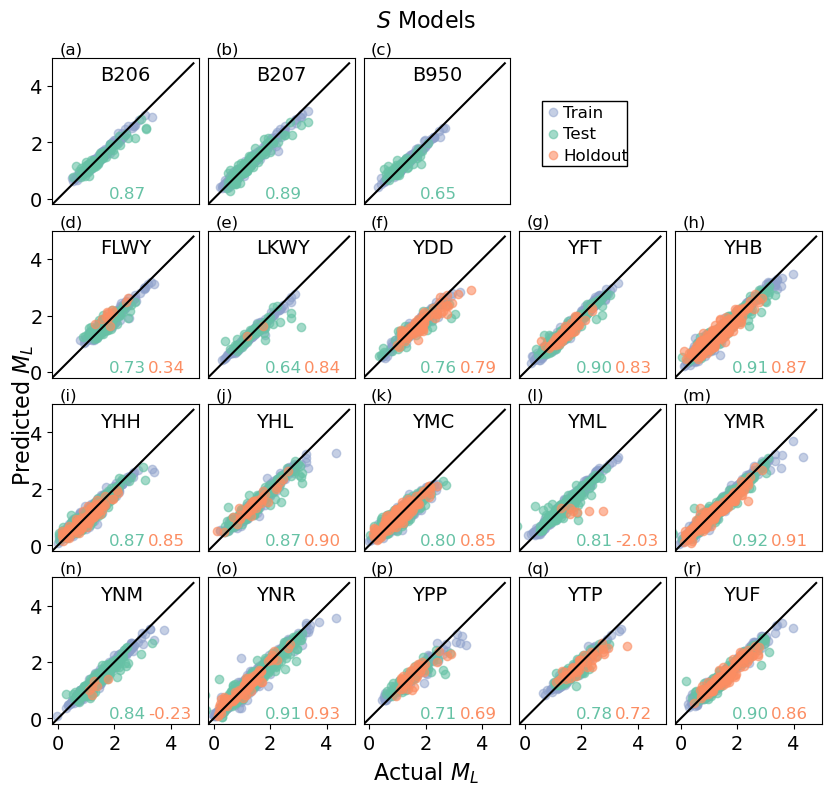

In [15]:
plotting.actual_v_predicted(results_df,
                     train_preds_df, 
                     test_preds_df,
                     holdout_preds_df,
                     inner_ticks_on=False,
                     title='$\it S$ Models',
                     figsize=(8, 7.5),
                     colors=['#8da0cb', '#66c2a5', '#fc8d62'],
                     alphas=[0.5, 0.6, 0.6],
                     linestyle='-',
                     n_cols=5)

# Average the predictions

In [16]:
test_avg_df = compute_network_avg_prediction(test_preds_df)
holdout_avg_df = compute_network_avg_prediction(holdout_preds_df)

In [17]:
(test_avg_df['magnitude'] - test_avg_df['predicted_magnitude']).describe()

count    1312.000000
mean        0.010784
std         0.162705
min        -1.181501
25%        -0.071577
50%         0.006060
75%         0.093462
max         0.975063
dtype: float64

In [18]:
(holdout_avg_df['magnitude'] - holdout_avg_df['predicted_magnitude']).describe()

count    436.000000
mean       0.016023
std        0.165274
min       -0.483130
25%       -0.084601
50%        0.001245
75%        0.102203
max        0.887310
dtype: float64

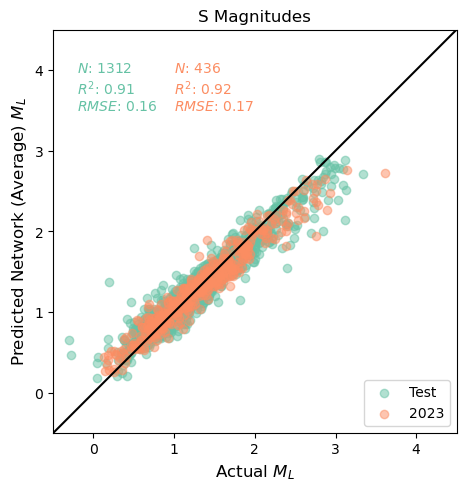

In [19]:
plotting.actual_v_network_avg_prediction([test_avg_df, holdout_avg_df],
                                    title='S Magnitudes',
                                    plot_lims=[-0.5, 4.5],
                                    alphas=[0.5, 0.5],
                                    legend_labels=['Test', '2023'],
                                    plot_legend=True,
                                    marker_colors=['#66c2a5', '#fc8d62'],
                                    text_x = [-0.2, 0.0],
                                    text_y=[-1.0, -1.0])

In [20]:
train_preds_df.iloc[train_preds_df['magnitude'].argmax()]

Evid                   60203137
magnitude              4.326333
predicted_magnitude    3.260061
station                     YHL
Name: 96, dtype: object

In [21]:
holdout_preds_df.iloc[holdout_preds_df['magnitude'].argmax()]

Evid                   60535541
magnitude              3.615056
predicted_magnitude    2.904016
station                     YDD
Name: 22, dtype: object

In [22]:
test_preds_df.iloc[test_preds_df['magnitude'].argmax()]

Evid                   60045887
magnitude              3.344134
predicted_magnitude    2.726648
station                     YHB
Name: 35, dtype: object